# Tutorial 3: Human Tonsil (RNA + Protein Epitopes)

Welcome to this tutorial on using the `mTopic` package for spatial multimodal topic modeling of the human tonsil dataset. We use a publicly available dataset from [10x Genomics](https://www.10xgenomics.com/datasets/gene-protein-expression-library-of-human-tonsil-cytassist-ffpe-2-standard), which includes RNA and protein epitope measurements.

Let us begin by importing the required libraries and downloading the filtered training data, available at [Zenodo](https://doi.org/10.5281/zenodo.15471869).

In [1]:
import mtopic

! wget -O Human_Tonsil_RNA_Protein_filtered.h5mu \
  "https://zenodo.org/records/15471869/files/Human_Tonsil_RNA_Protein_filtered.h5mu?download=1"

--2025-05-20 13:58:20--  https://zenodo.org/records/15471869/files/Human_Tonsil_RNA_Protein_filtered.h5mu?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16108621 (15M) [application/octet-stream]
Saving to: ‘Human_Tonsil_RNA_Protein_filtered.h5mu’

Human_Tonsil_RNA_Pr 100%[===================>]  15.36M  31.1MB/s    in 0.5s    

2025-05-20 13:58:21 (31.1 MB/s) - ‘Human_Tonsil_RNA_Protein_filtered.h5mu’ saved [16108621/16108621]



## Spatial Multimodal Topic Modeling

Load the prefiltered `MuData` object containing the human tonsil dataset. This dataset includes 4,194 spatial spots and two modalities:

- `rna`: gene expression data,
- `prot`: protein abundance data.

In [2]:
ton = mtopic.read.h5mu('Human_Tonsil_RNA_Protein_filtered.h5mu')

ton

MuData object with n_obs × n_vars = 4194 × 5027
  obs:	'in_tissue'
  var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
  obsm:	'coords'
  2 modalities
    rna:	4194 x 5000
      obs:	'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
    prot:	4194 x 27
      obs:	'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'

Before training the spatial Multimodal Topic Model (`mtopic.tl.sMTM`), it is essential to preprocess the data to improve the model's ability to identify meaningful patterns across modalities.

To ensure comparability between RNA and protein epitope data, we apply the following normalization and scaling steps:

- **TF-IDF transformation for RNA** (`mtopic.pp.tfidf`):  
  Adjusts raw gene expression counts by balancing feature frequency and importance, emphasizing rare but informative genes.

- **CLR normalization for protein** (`mtopic.pp.clr`):  
  Corrects compositional biases by normalizing protein counts across cells using the Centered Log Ratio method.

- **Scaling across modalities** (`mtopic.pp.scale_counts`):  
  Linearly scales counts to ensure all modalities contribute equally during topic modeling, preventing one from dominating the analysis.

In [3]:
mtopic.pp.tfidf(ton, mod='rna')
mtopic.pp.clr(ton, mod='prot')
mtopic.pp.scale_counts(ton)

Now that the data is preprocessed, we can train the spatial Multimodal Topic Model (`sMTM`). Initialize and train the model.

In [4]:
sMTM = mtopic.tl.sMTM(ton, n_topics=19, radius=0.02, n_jobs=100)
sMTM.VI(n_iter=20)

100%|███████████████████████████████████████████| 20/20 [01:05<00:00,  3.29s/it]


After training, export the learned parameters to the `MuData` object using `mtopic.pp.export_params`.

In [5]:
mtopic.tl.export_params(sMTM, ton)

ton

MuData object with n_obs × n_vars = 4194 × 5027
  obs:	'in_tissue'
  var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
  obsm:	'coords', 'topics'
  2 modalities
    rna:	4194 x 5000
      obs:	'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
      varm:	'signatures'
    prot:	4194 x 27
      obs:	'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
      varm:	'signatures'

## Visualizing Human Tonsil Results

To visualize topic-spot distribution, use the `mtopic.pl.topics` function to generate scatter plots where each cell or spot is colored according to the value of a selected topic. This reveals spatial patterns and gradients that help interpret biological variation within the tissue.

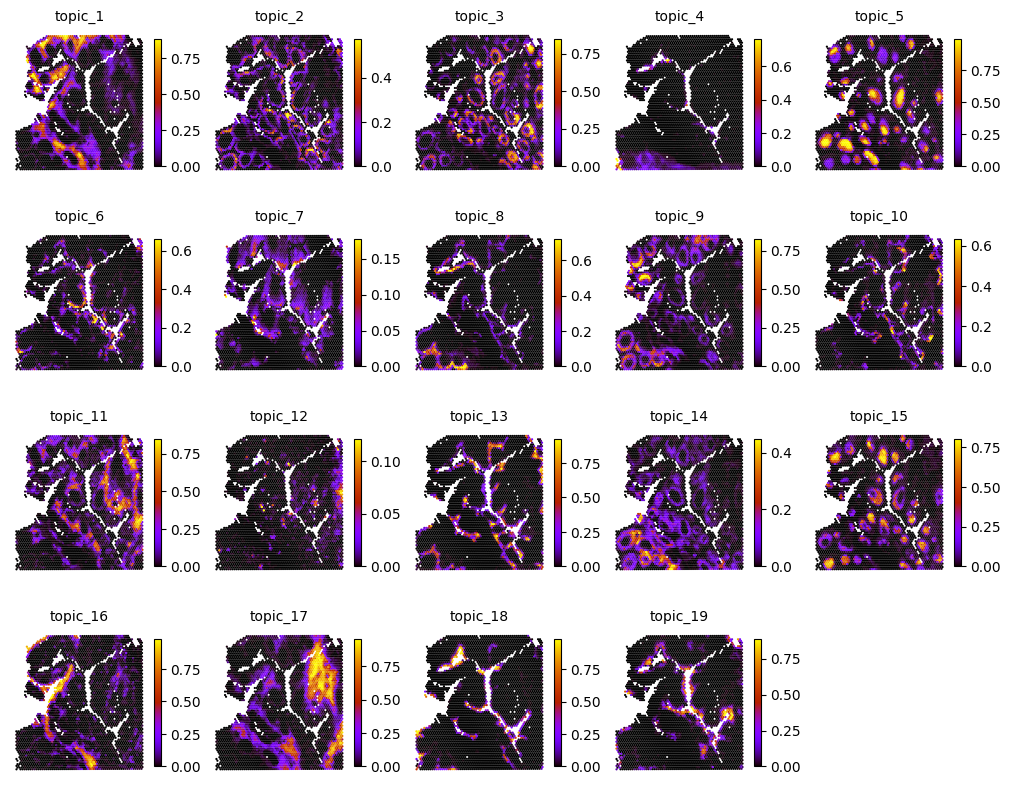

In [6]:
mtopic.pl.topics(ton, x='coords')

To visualize overall trends in topic distributions, use the `mtopic.pl.dominant_topics` function. This function assigns each cell or spot to its most dominant topic, the one with the highest probability, and colors it accordingly.

The resulting plot provides a global overview of topic dominance across the tissue, helping you quickly identify regions enriched in specific topics. These regions may correspond to distinct cell types, tissue structures, or gradients of biological activity.

This visualization is handy for detecting the tissue's spatial domains and functional zones.

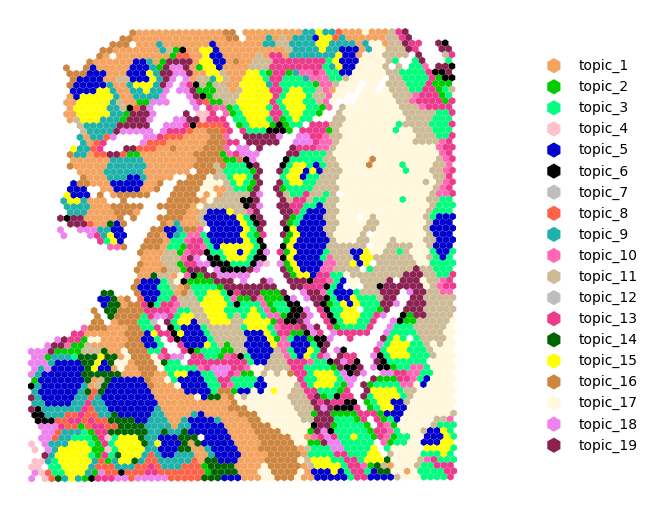

In [7]:
palette = {'topic_1': '#F4A460', 'topic_2': '#00CD00', 'topic_3': '#00FF7F',
           'topic_4': '#FFC0CB', 'topic_5': '#0000CD', 'topic_6': '#000000',
           'topic_7': '#BEBEBE', 'topic_8': '#FF6347', 'topic_9': '#20B2AA',
           'topic_10': '#FF69B4', 'topic_11': '#CDBA96', 'topic_12': '#BEBEBE',
           'topic_13': '#EE3A8C', 'topic_14': '#006400', 'topic_15': '#FFFF00',
           'topic_16': '#CD853F', 'topic_17': '#FFF8DC', 'topic_18': '#EE82EE',
           'topic_19': '#8B2252'}

mtopic.pl.dominant_topics(ton, x='coords', marker='h', s=30, palette=palette)

Alternatively, you can explore topic-spot distribution in more detail using pie chart scatter plots with `mtopic.tl.scatter_pie`. This function visualizes the complete topic composition of each cell or spot as a pie chart.

Rendering may take time, especially for large datasets. To improve performance and focus on a specific region, you can limit the number of visualized spots using the `xrange` and `yrange` parameters (default: `[0, 1]`), which define the fraction of the spatial extent to display.

100%|█████████████████████████████████████████| 427/427 [00:08<00:00, 48.80it/s]


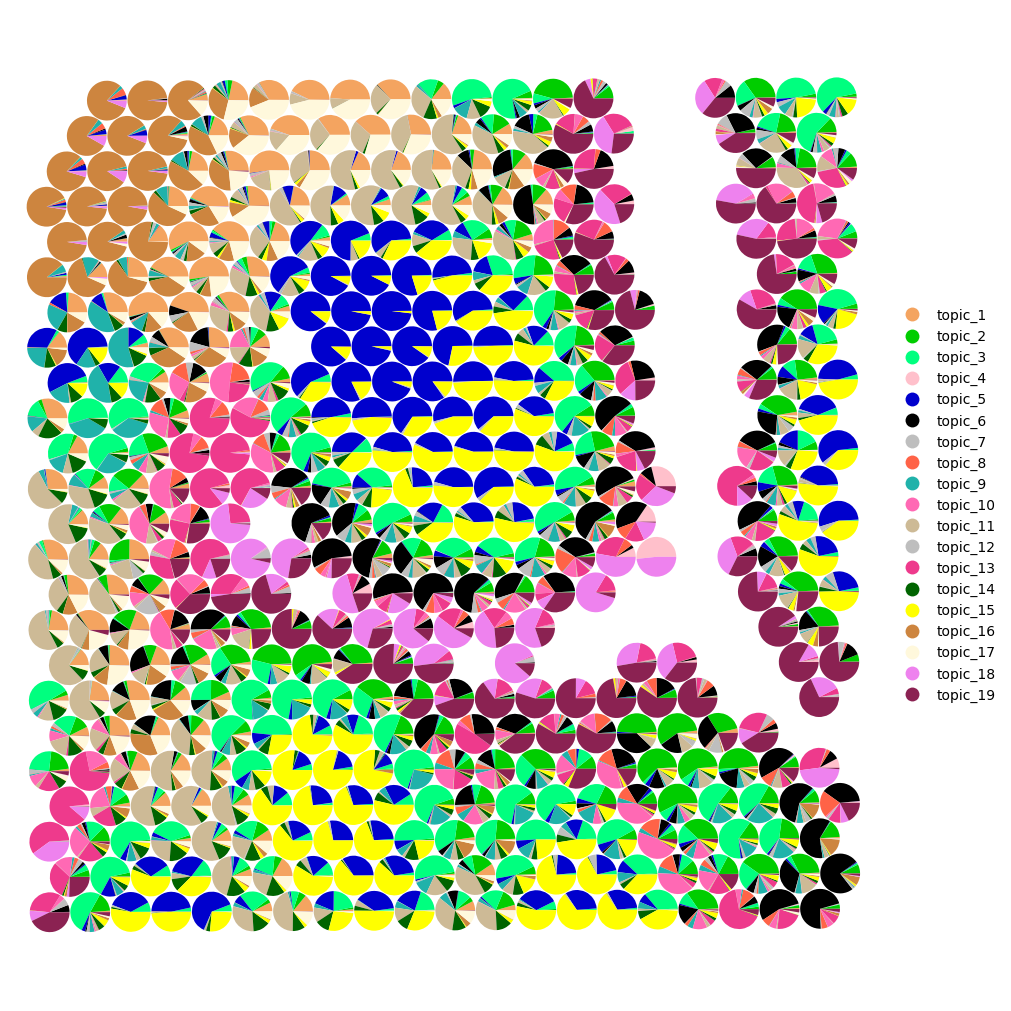

In [8]:
mtopic.pl.scatter_pie(ton, x='coords', radius=0.0073, palette=palette, xrange=[0.3, 0.6], yrange=[0.35, 0.65])

To interpret the results of the `sMTM` model, it is important to examine the feature signatures associated with each topic. Use the `mtopic.pl.signatures` function to visualize the top features per topic. These visualizations help reveal which molecular markers distinguish topics, aiding in biological interpretation and annotation of the results.

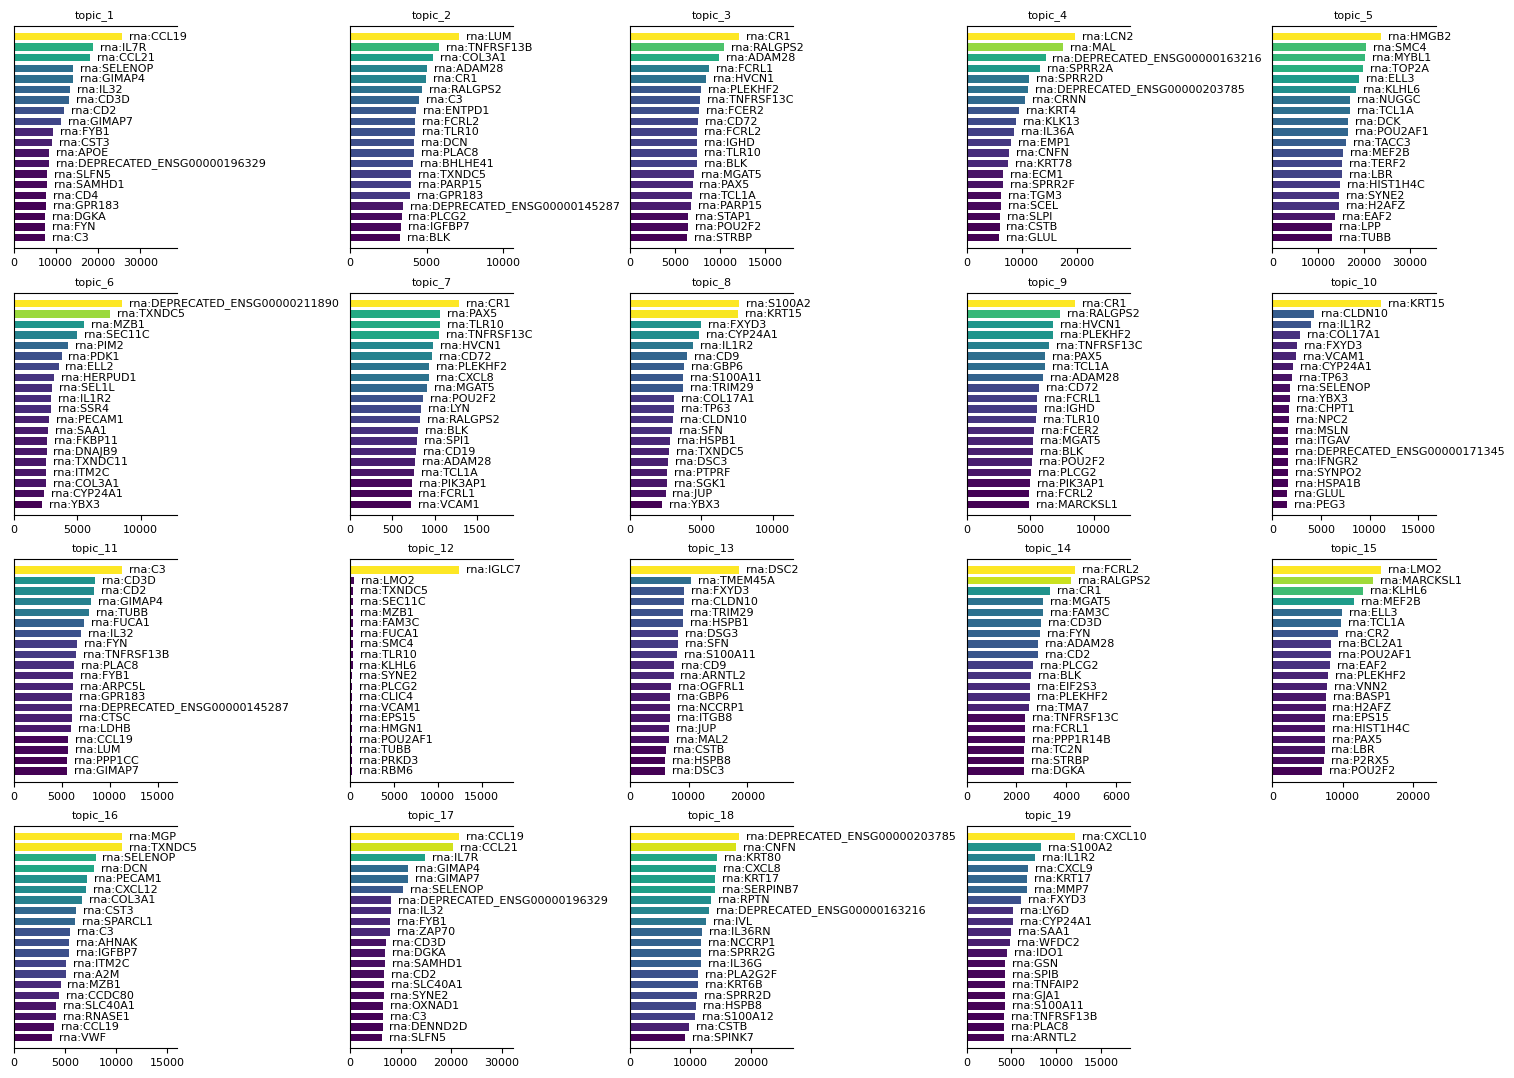

In [9]:
mtopic.pl.signatures(ton, mod='rna', n_top=20)

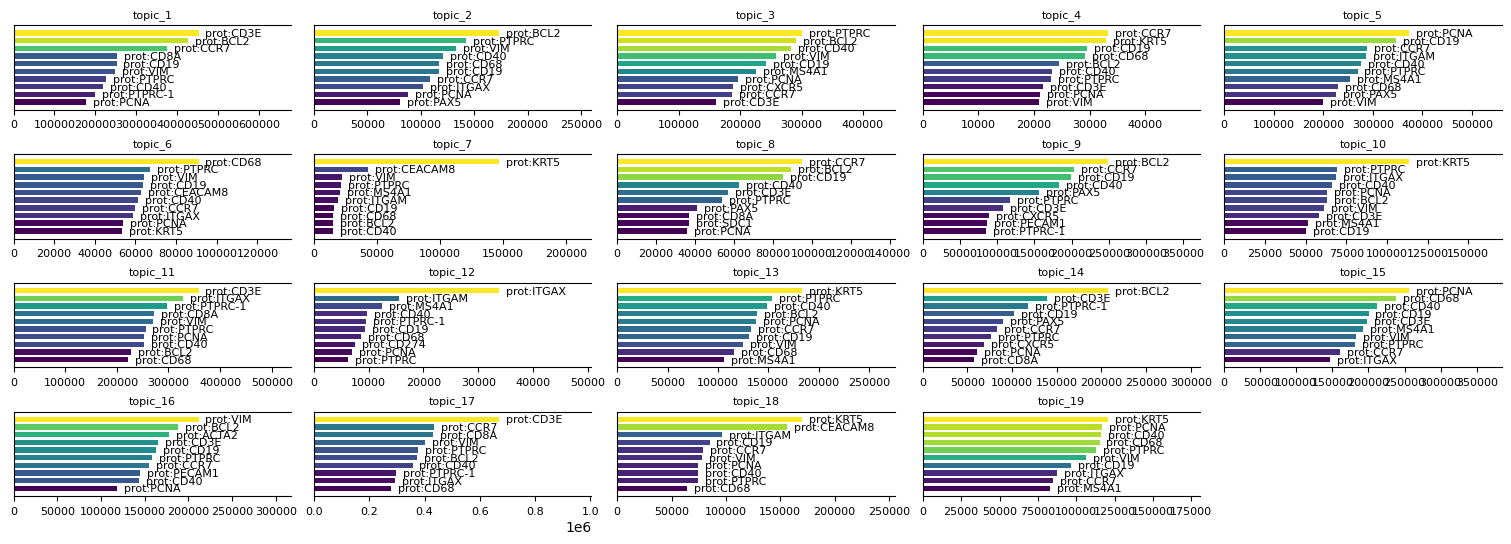

In [10]:
mtopic.pl.signatures(ton, mod='prot', n_top=10)

This concludes the application of `mTopic` for modeling spatial multimodal single-cell data, demonstrated using the human tonsil dataset.

In [11]:
#ton.write('Human_Tonsil_RNA_Protein_trained.h5mu')